# Import

In [1]:
import torch
import os
from matplotlib import pyplot as plt
import numpy as np

from PIL import Image

from fitting.FittingConfiguration import FittingConfiguration
from utils.image_helpers import plot_image_grid, get_images
from models.model_creation import create_model_from_configuration
from fitting.Fitter import create_fitter_from_configuration
from simulation.SimulationPipeline import SimulationPipeline
from utils.evaluation_helpers import performance_from_images

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Load Image and Add Artifacts

In [2]:
image_path = 'data/raw_images/sample_images/cameraman.png'
k_factor = 0.15
snr = 64
pf_factor = 1.0

(256, 256, 1)


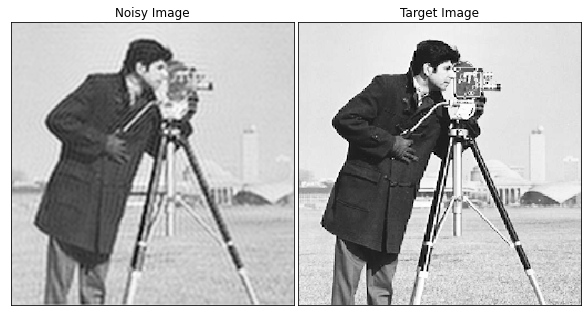

In [3]:
target_image = np.array(Image.open(image_path).convert('L'))[:,:,None]
target_image = target_image.astype(np.float32)/255
image_dimensions = target_image.shape
print(image_dimensions)

pipeline = SimulationPipeline(k_factor, snr, pf_factor)
noisy_image = pipeline.simulate(target_image)

plot_image_grid([noisy_image, target_image], ['Noisy Image', 'Target Image'])
plt.show()

# Configuration

In [4]:
fit_model_configuration = FittingConfiguration()

fit_model_configuration.model_type = 'deep'
fit_model_configuration.input_shape = [16, 16]
fit_model_configuration.number_of_hidden_channels = 40
fit_model_configuration.number_of_layers = 5

fit_model_configuration.log_frequency = 100
fit_model_configuration.convergence_check_length = None
fit_model_configuration.number_of_iterations = 10000

fit_model_configuration.result_path = None
fit_model_configuration.image_dimensions = image_dimensions
fit_model_configuration.save_losses = False
fit_model_configuration.find_best = False
fit_model_configuration.constant_input = True

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(str(fit_model_configuration))

image_dimensions: (256, 256, 1)  
result_path: None  
model_type: deep  
input_shape: [16, 16]  
number_of_layers: 5  
number_of_hidden_channels: 40  
number_of_iterations: 10000  
number_of_runs: 10  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 100  
find_best: False  
save_losses: False  
constant_input: True  
data_type: <class 'torch.cuda.FloatTensor'>  



# Fitting

In [5]:
number_of_models = 10
number_of_intervals = 20
size_of_interval = int(fit_model_configuration.number_of_iterations/number_of_intervals)
fit_model_configuration.number_of_iterations = size_of_interval

In [6]:
numbers_of_results = range(1,number_of_models)

In [7]:
models = []
fitters = []
for _ in range(number_of_models):
    models.append(create_model_from_configuration(fit_model_configuration))
    fitters.append(create_fitter_from_configuration(fit_model_configuration))

In [8]:
model_step_images = []
for interval_index in range(number_of_intervals):
    step_images = []
    for model_index, (model, fitter) in enumerate(zip(models, fitters)):
        log_prefix = f'{interval_index + 1}/{number_of_intervals}, {model_index + 1}/{number_of_models}; '
        fitter(model, noisy_image, target_image, log_prefix=log_prefix)
        step_images.append(fitter.get_best_image())
    model_step_images.append(step_images)

# Combining Images & Calculating Performances

In [9]:
def average_images(image_list):
    return np.mean(np.array(image_list), axis=0)

def median_images(image_list):
    return np.median(np.array(image_list), axis=0)

functions = {'Median Image': median_images, 'Average Image': average_images}

for function in functions:
    print(function)

Median Image
Average Image


In [ ]:
avg_performances = []
for step_index, step_images in enumerate(model_step_images):
    print(f'{step_index+1}/{len(model_step_images)}', end='\r')
    for number_of_models in range(len(step_images)):
        for function in functions:
            perf_id = {'number of models': number_of_models, 'function': functions[function], 'step': step_index} 
            avg_image = np.mean(np.array(step_images[:number_of_models+1]), axis=0)
            performance_noisy = performance_from_images(avg_image, noisy_image, {'type': 'noisy', **perf_id})
            performance_target = performance_from_images(avg_image, target_image, {'type': 'target', **perf_id})
            avg_performances.append(performance_noisy)
            avg_performances.append(performance_target)
measures = [key for key in avg_performances[0].keys() if key != 'id']
print(measures)

noisy_baseline = performance_from_images(noisy_image, target_image)

# Compare Performance wrt noisy & target

In [ ]:
def generate_plot_vectors(perfs, y_key, x_key='k_factor'):
    x_vec = [x['id'][x_key] for x in perfs]
    y_vec = [y[y_key] for y in perfs]
    return x_vec, y_vec

In [ ]:
max_num_performances = [x for x in avg_performances if x['id']['number of models'] == number_of_models]

In [ ]:
figure, axes = plt.subplots(1, len(measures), figsize=(len(measures)*6, 6))
for axis, measure in zip(axes, measures):
    for performance_type in ['noisy', 'target']:
        filtered_performances = [x for x in max_num_performances if x['id']['type'] == performance_type]
        x_vec, y_vec = generate_plot_vectors(filtered_performances, measure, 'step')
        axis.plot(x_vec, y_vec, label=performance_type)
    axis.set_xlabel('step')
    axis.set_ylabel(measure)
    axis.legend()
    axis.set_title(measure.upper())

# Compare Combination Functions

In [ ]:
figure, axes = plt.subplots(1, len(measures), figsize=(len(measures)*6, 6))
for axis, measure in zip(axes, measures):
    for function in functions:
        filtered_performances = [x for x in max_num_performances if x['id']['type'] == functions[function]]
        x_vec, y_vec = generate_plot_vectors(filtered_performances, measure, 'step')
        axis.plot(x_vec, y_vec, label=performance_type)
    axis.set_xlabel('step')
    axis.set_ylabel(measure)
    axis.legend()
    axis.set_title(measure.upper())

In [ ]:
measures = [key for key in performances[0].keys() if key != 'id']
print(measures)
figure, axes = plt.subplots(1, len(measures), figsize=(len(measures)*6, 6))

for index, (axis, measure) in enumerate(zip(axes, measures)):
    for performance_type in ['noisy', 'target']:
        x_vec, y_vec = generate_plot_vectors(avg_performances, image_type, measure)
        axis.plot(x_vec, y_vec, label=image_type)
    axis.legend()
    axis.set_title(measure.upper())

In [10]:
losses_wrt_noisy = {}
losses_wrt_target = {}
model_images = {}

for number_of_results in numbers_of_results:
    losses_wrt_noisy[number_of_results] = []
    losses_wrt_target[number_of_results] = []
    model_images[number_of_results] = []

for step_results in results:
    for number_of_results in numbers_of_results:
        result = calculate_combination_results(step_results[:number_of_results])[0]
        losses_wrt_noisy[number_of_results].append(result.best_loss_wrt_noisy)
        losses_wrt_target[number_of_results].append(result.loss_wrt_target)
        model_images[number_of_results].append(result.model_image)

['mse', 'psnr', 'vif', 'ssim']


TypeError: performance_from_images() missing 1 required positional argument: 'id'

# Compare Performance wrt noisy & target

In [ ]:
def generate_plot_vectors(perfs, y_key, x_key='k_factor'):
    x_vec = [x['id'][x_key] for x in perfs]
    y_vec = [y[y_key] for y in perfs]
    return x_vec, y_vec

In [ ]:
max_num_performances = [x for x in avg_performances if x['id']['number of models'] == number_of_models]

In [ ]:
figure, axes = plt.subplots(1, len(measures), figsize=(len(measures)*6, 6))
for axis, measure in zip(axes, measures):
    for performance_type in ['noisy', 'target']:
        filtered_performances = [x for x in max_num_performances if x['id']['type'] == performance_type]
        x_vec, y_vec = generate_plot_vectors(filtered_performances, measure, 'step')
        axis.plot(x_vec, y_vec, label=performance_type)
    axis.set_xlabel('step')
    axis.set_ylabel(measure)
    axis.legend()
    axis.set_title(measure.upper())

# Compare Combination Functions

In [ ]:
figure, axes = plt.subplots(1, len(measures), figsize=(len(measures)*6, 6))
for axis, measure in zip(axes, measures):
    for function in functions:
        filtered_performances = [x for x in max_num_performances if x['id']['type'] == functions[function]]
        x_vec, y_vec = generate_plot_vectors(filtered_performances, measure, 'step')
        axis.plot(x_vec, y_vec, label=performance_type)
    axis.set_xlabel('step')
    axis.set_ylabel(measure)
    axis.legend()
    axis.set_title(measure.upper())

In [ ]:
measures = [key for key in performances[0].keys() if key != 'id']
print(measures)
figure, axes = plt.subplots(1, len(measures), figsize=(len(measures)*6, 6))

for index, (axis, measure) in enumerate(zip(axes, measures)):
    for performance_type in ['noisy', 'target']:
        x_vec, y_vec = generate_plot_vectors(avg_performances, image_type, measure)
        axis.plot(x_vec, y_vec, label=image_type)
    axis.legend()
    axis.set_title(measure.upper())

In [ ]:
losses_wrt_noisy = {}
losses_wrt_target = {}
model_images = {}

for number_of_results in numbers_of_results:
    losses_wrt_noisy[number_of_results] = []
    losses_wrt_target[number_of_results] = []
    model_images[number_of_results] = []

for step_results in results:
    for number_of_results in numbers_of_results:
        result = calculate_combination_results(step_results[:number_of_results])[0]
        losses_wrt_noisy[number_of_results].append(result.best_loss_wrt_noisy)
        losses_wrt_target[number_of_results].append(result.loss_wrt_target)
        model_images[number_of_results].append(result.model_image)

# Display Results

In [ ]:
steps = np.arange(number_of_intervals)*size_of_interval + size_of_interval

In [ ]:
fig = plt.figure(figsize = (5,5))
plt.plot(steps, losses_wrt_noisy[np.max(numbers_of_results)], label = "Loss with respect to noisy image")
plt.plot(steps, losses_wrt_target[np.max(number_of_results)], label = "Loss with respect to target image")
plt.xlabel('Number of Steps')
plt.ylabel('MSE')
plt.title('Overfitting')
plt.ylim(0,min(0.5,1.1 * np.max(losses_wrt_noisy[np.max(number_of_results)])))
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize = (15,15))
for number_of_results in numbers_of_results:
    plt.plot(steps, losses_wrt_target[number_of_results], label=str(number_of_results))
plt.xlabel('Number of Steps')
plt.ylabel('MSE Loss wrt Target')
plt.title('Performance of different number of reconstructions')
plt.legend()
plt.show()

In [ ]:
titles = ['Noisy Image'] + ['Deep Decoder at Step: ' + str(x) for x in steps] + ['Target Image']
images = [noisy_image] + model_images[numbers_of_results[-1]] + [target_image]
plot_image_grid(images, titles, ncols=3)
plt.show()

In [ ]:
convergence_step_limit = 2000
convergence_limit = int(convergence_step_limit / size_of_interval)

figure, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].set_title('Average Loss with respect to target')
axes[0].set_xlabel('Number of reconstructions used')
axes[0].set_ylabel('Average Loss with respect to target')
axes[1].set_title('Standard Deviation of Loss with respect to target')
axes[1].set_xlabel('Number of reconstructions used')
axes[1].set_ylabel('Standard Deviation of Loss with respect to target')

averages = []
standard_deviations = []

for number_of_results in numbers_of_results:
    average = np.mean(losses_wrt_target[number_of_results][convergence_limit:])
    averages.append(average)
    std = np.std(losses_wrt_target[number_of_results][convergence_limit:])
    standard_deviations.append(std)
    
axes[0].plot(numbers_of_results, averages)
axes[1].plot(numbers_of_results, standard_deviations)
plt.show()